# GP Version GR00T Inference vs. GT
Done a lot of ploting in this notebook for better understanding.

In [ ]:
import os
os.environ["HF_HOME"] = "/data0/fredhong/hf_models/"
import sys
sys.path.append("/home/fredhong/gr00t4gp-origin")
import torch
import gr00t

from gr00t.data.dataset import LeRobotSingleDataset
from gr00t.model.policy import Gr00tPolicy

In [2]:
# change the following paths
# MODEL_PATH = "nvidia/GR00T-N1-2B"
MODEL_PATH = "/data0/fredhong/hf_models/hub/gr00t/"

# REPO_PATH is the path of the pip install gr00t repo and one level up
EMBODIMENT_TAG = "gr1"
device = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_PATH = "/home/fredhong/gr00t4gp-origin/demo_data/robot_sim.PickNPlace"
VLM_MODEL = "lavida"  # we specify to use the bidirectional masking diffusion LM lavida as the vlm backbone

## Loading Pretrained Policy

Policy Model is loaded just like any other huggingface model.

There are 2 new concepts here in the GR00T model:
 - modality config: This defines the keys in the dictionary used by the model. (e.g. `action`, `state`, `annotation`, `video`)
 - modality_transform: A sequence of transform which are used during dataloading

In [ ]:
from gr00t.model.backbone.eagle2_hg_model.inference_eagle_repo import EagleProcessor, ModelSpecificValues
from gr00t.experiment.data_config import Gr1ArmsOnlyDataConfig

# data_config = DATA_CONFIG_MAP["gr1_arms_only"]  # this by default goes to raw eagleprocessor, below we init a eagleprocessor instance but with pretrainedtokenizerfast
model_spec = ModelSpecificValues(
    template="qwen2-chat",
    num_image_token=1,   # change from 64 to 1 compared with Eagle2
) if VLM_MODEL=="lavida" else None

# # I wanna use eagle2 tokenizer while using llavida model here
# VLM_MODEL = "eagle2"  # while making config json model type lavida

vlm_processor = EagleProcessor(model_spec=model_spec, 
                                use_lavida_tokenizer=False,
                            #    use_lavida_tokenizer=VLM_MODEL=="lavida"
                               )
# if not pass in lavida vlm proc then by default eagleprocessor
data_config = Gr1ArmsOnlyDataConfig(vlm_processor)

modality_config = data_config.modality_config()
modality_transform = data_config.transform()

policy = Gr00tPolicy(
    model_path=MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
    model_type=VLM_MODEL
)

# print out the policy model architecture
print(policy.model)

## Loading dataset

First this requires user to check which embodiment tags are used to pretrained the `Gr00tPolicy` pretrained models.

In [4]:
import numpy as np

modality_config = policy.modality_config

print(modality_config.keys())

for key, value in modality_config.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)


dict_keys(['video', 'state', 'action', 'language'])
video delta_indices=[0] modality_keys=['video.ego_view']
state delta_indices=[0] modality_keys=['state.left_arm', 'state.right_arm', 'state.left_hand', 'state.right_hand']
action delta_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] modality_keys=['action.left_arm', 'action.right_arm', 'action.left_hand', 'action.right_hand']
language delta_indices=[0] modality_keys=['annotation.human.action.task_description']


In [5]:
DATASET_PATH = "/home/fredhong/gr00t4gp-origin/demo_data/robot_sim.PickNPlace"
# Create the dataset
dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
)

Initialized dataset robot_sim.PickNPlace with gr1


Let's print out a single data and visualize it

In [6]:
import numpy as np

step_data = dataset[0]

# print(step_data)

print("\n\n ====================================")
for key, value in step_data.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)




video.ego_view (1, 256, 256, 3)
state.left_arm (1, 7)
state.right_arm (1, 7)
state.left_hand (1, 6)
state.right_hand (1, 6)
action.left_arm (16, 7)
action.right_arm (16, 7)
action.left_hand (16, 6)
action.right_hand (16, 6)
annotation.human.action.task_description ['pick the pear from the counter and place it in the plate']


Let's plot just the "right hand" state and action data and see how it looks like. Also show the images of the right hand state.

Now we can run the policy from the pretrained checkpoint.

In [7]:
predicted_action = policy.get_action(step_data)
for key, value in predicted_action.items():
    print(key, value.shape)

action.left_arm (16, 7)
action.right_arm (16, 7)
action.left_hand (16, 6)
action.right_hand (16, 6)


In [8]:
step_data['action.left_arm'][:,0]

array([-0.01077067, -0.00791579, -0.0054817 , -0.00323208, -0.00103296,
        0.00118218,  0.00401225,  0.00570485,  0.0073973 ,  0.00912184,
        0.01099922,  0.01306627,  0.01520621,  0.01731082,  0.0192511 ,
        0.02071264])

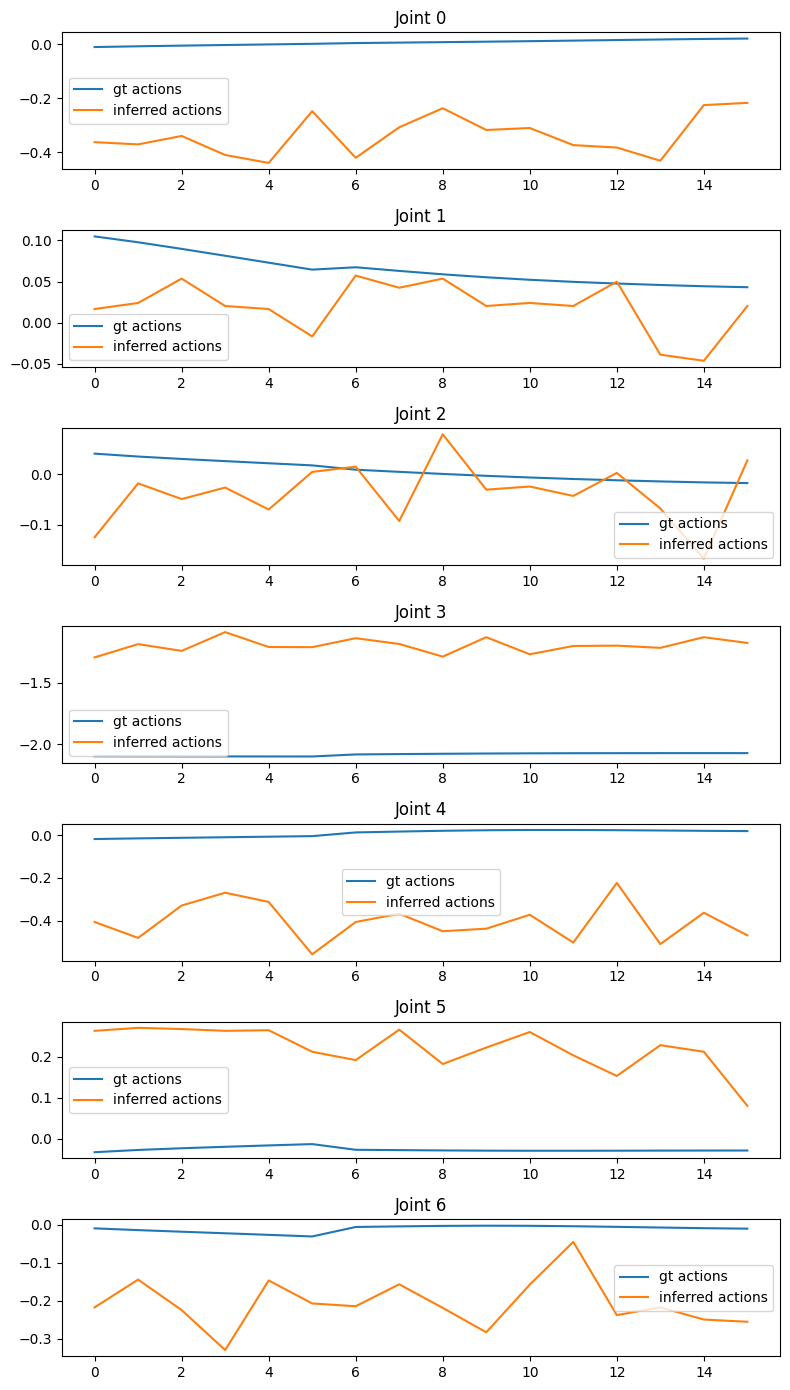

In [9]:

import matplotlib.pyplot as plt
# Plot inferred actions vs. gt actions
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 2*7))

for i, ax in enumerate(axes):
    ax.plot(step_data['action.left_arm'][:, i], label="gt actions")
    ax.plot(predicted_action['action.left_arm'][:, i], label="inferred actions")
    ax.set_title(f"Joint {i}")
    ax.legend()

plt.tight_layout()
plt.show()

### Understanding the Action Output

Each joint in the action output has a shape of (16, N) where N is the degree of freedom for the joint.
- 16 represents the action horizon (predictions for timesteps t, t+1, t+2, ..., t+15)

For each arm (left and right):
- 7 arm joints:
  - Shoulder pitch
  - Shoulder roll
  - Shoulder yaw
  - Elbow pitch
  - Wrist yaw
  - Wrist roll
  - Wrist pitch

For each hand (left and right):
- 6 finger joints:
  - Little finger
  - Ring finger
  - Middle finger
  - Index finger
  - Thumb rotation
  - Thumb bending

For the waist
- 3 joints:
  - torso waist yaw
  - torso waist pitch
  - torso waist roll
